In [1]:
import os
import time
import argparse
import numpy as np

import torch
import torch.optim as optim
import torch.cuda.amp as amp
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

import libs.trainer as trainer
from libs.model.model import ROG
from settings import plan_experiment
from libs.autoattack import AutoAttack
from libs.dataloader import dataloader, helpers
from libs.utilities import losses, utils, test, test_pgd

import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
import torchio as tio
import matplotlib.pyplot as plt
%matplotlib inline
import csv

In [2]:
tasks = {
    '1': 'Task01_BrainTumour',
    '2': 'Task02_Heart',
    '3': 'Task03_Liver',
    '4': 'Task04_Hippocampus',
    '5': 'Task05_Prostate',
    '6': 'Task06_Lung',
    '7': 'Task07_Pancreas',
    '8': 'Task08_HepaticVessel',
    '9': 'Task09_Spleen',
    '10': 'Task10_Colon',
    '11': 'Task11_KiTS'
}

def setup(rank, world_size, port):
    os.environ['MASTER_ADDR'] = 'localhost'
    os.environ['MASTER_PORT'] = '1234' + port

    # initialize the process group
    dist.init_process_group("nccl", rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)


def cleanup():
    dist.destroy_process_group()

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.environ['MKL_THREADING_LAYER'] = 'GNU'

rank = 0
world_size = 1

print(f"Running on rank {rank}.")
setup(rank, world_size, "5")

Running on rank 0.


In [66]:
info, model_params = plan_experiment(
    tasks["2"], 2, 50, 0, rank)
print(info)
with open(info['train_file'], 'r') as file:
    reader = csv.reader(file)
    data = list(reader)[1:]

Current task is Task02_Heart, with 1 modalities and 2 classes
The mean size of the images in this dataset is: [320.0, 320.0, 115.0]
--- Training input size set to [192, 192, 96] ---
--- Validation input size set to [192, 192, 96] ---
{'task': 'Task02_Heart', 'classes': 2, 'p_size': [212, 212, 96], 'in_size': [192, 192, 96], 'val_size': [192, 192, 96], 'test_size': [192, 192, 96], 'batch': 2, 'test_batch': 2, 'patience': 50, 'seed': 12345, 'output_folder': 'Results/Task02_Heart', 'root': '/datasets/MSD_data/processed/Task02_Heart', 'train_file': 'Tasks/Task02_Heart/train_fold0.csv', 'val_file': 'Tasks/Task02_Heart/val_fold0.csv', 'test_file': 'Tasks/Task02_Heart/val_fold0.csv'}


In [67]:
subjects = []
for image_path, label_path in data:
    subject = tio.Subject(
        image=tio.ScalarImage(os.path.join(info["root"], image_path[2:])),
        label=tio.LabelMap(os.path.join(info["root"], label_path[2:])),
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)

6
ScalarImage(shape: (1, 320, 320, 109); spacing: (1.25, 1.25, 1.37); orientation: RAS+; dtype: torch.FloatTensor; memory: 42.6 MiB)
LabelMap(shape: (1, 320, 320, 109); spacing: (1.25, 1.25, 1.37); orientation: RAS+; dtype: torch.ByteTensor; memory: 10.6 MiB)
1


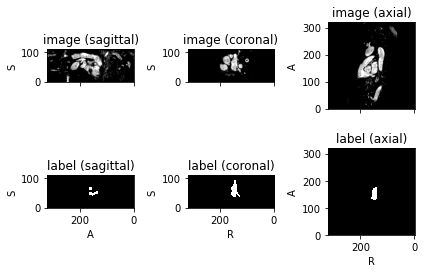

In [68]:
rand_num = np.random.randint(1, 10)
print(rand_num)
one_subject = dataset[rand_num]
# print(one_subject)
print(one_subject.image)
print(one_subject.label)
print(one_subject.label.numpy().max())
one_subject.plot()

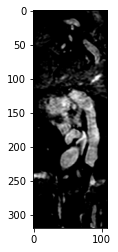

In [71]:
plt.imshow(one_subject.image.numpy()[0,:,:,:], cmap='gray')

In [77]:
one_subject.label.data

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         ...,

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 

In [72]:
# from mpl_toolkits.mplot3d import Axes3D

{(0, 0, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f4301f09fa0>,
 (0, 0, 36): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f4301f16e20>,
 (0, 1, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f43020f1280>,
 (0, 1, 36): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f43020f16a0>,
 (0, 2, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f43020f1ac0>,
 (0, 2, 36): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f43020f1ee0>,
 (0, 3, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f430207f340>,
 (0, 3, 36): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f430207f760>,
 (0, 4, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f430207fb80>,
 (0, 4, 36): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f430207ffa0>,
 (0, 5, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f4302089400>,
 (0, 5, 36): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f4302089820>,
 (0, 6, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x7f430208

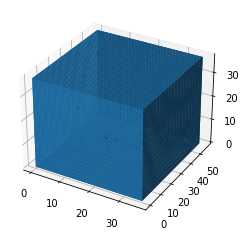

In [75]:
# test_image = one_subject.image.numpy().squeeze()
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.voxels(image)